# **Harreman tutorial: Metabolic crosstalk on the 10x Visium mouse colon dataset**

In [1]:
import harreman
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import mplscience
from scipy.stats import pearsonr, wilcoxon, mannwhitneyu, spearmanr
import random
import scipy.stats as stats
from sklearn import linear_model
from scipy.stats import hypergeom, zscore, norm
from statsmodels.stats.multitest import multipletests
from plotnine import *
import warnings
warnings.filterwarnings("ignore")


BASE_PATH = "/home/projects/nyosef/oier/Harreman_files/Visium_colon"
ADATA_PATH = os.path.join(BASE_PATH, 'h5ads')
DATA_PATH = os.path.join(BASE_PATH, 'data')
PLOTS_PATH = os.path.join(BASE_PATH, 'plots')

In [2]:
adata = harreman.read_h5ad(os.path.join(ADATA_PATH, 'Visium_colon_Metabolic_Hotspot_unrolled.h5ad'))

## Cell type-agnostic Harreman analysis

#### Running the pipeline

In [3]:
def harreman_pipeline(adata, verbose=False):

    harreman.pp.extract_interaction_db(adata, species='mouse', database='both', verbose=verbose)
    
    harreman.tl.compute_knn_graph(adata, 
                           compute_neighbors_on_key="spatial_unrolled", 
                           n_neighbors=5,
                           weighted_graph=False,
                           sample_key='cond',
                           verbose=verbose)
    
    harreman.tl.apply_gene_filtering(adata, layer_key='counts', model='danb', autocorrelation_filt = True, verbose=verbose)

    harreman.tl.compute_gene_pairs(adata, ct_specific = False, verbose=verbose)

    harreman.tl.compute_cell_communication(adata, model='danb', M = 1000, test = "both", layer_key_p_test='counts', layer_key_np_test='log_norm', verbose=verbose)

    harreman.tl.select_significant_interactions(adata, test = "non-parametric", threshold = 0.05)

    return adata

In [4]:
adata = harreman_pipeline(adata, verbose=True)

Extracting interaction database...
Finished extracting interaction database in 1087.977 seconds
Computing the neighborhood graph...
Restricting graph within samples using 'cond'...


100%|██████████| 2/2 [00:00<00:00, 66.49it/s]

Computing the weights...
Finished computing the KNN graph in 0.056 seconds


Applying gene filtering...
Finished applying gene filtering in 1.157 seconds
Computing gene pairs...
Finished computing gene pairs in 2.032 seconds
Starting cell-cell communication analysis...
Running the parametric test...
Parametric test finished.
Running the non-parametric test...


Permutation test: 100%|██████████| 1000/1000 [00:24<00:00, 40.99it/s]


Non-parametric test finished.
Obtaining communication results...
Finished computing cell-cell communication analysis in 25.499 seconds


#### Computing interacting scores

In [5]:
harreman.tl.compute_interacting_cell_scores(adata, test = "both", verbose=True, device='cpu')

Computing gene pair and metabolite scores...
Running the parametric test...
Parametric test finished.
Running the non-parametric test...


Permutation test: 100%|██████████| 1000/1000 [03:06<00:00,  5.35it/s]


Non-parametric test finished.
Finished computing gene pair and metabolite scores in 191.049 seconds


In [6]:
harreman.tl.compute_interaction_module_correlation(adata, cor_method='pearson', use_super_modules=True, interaction_type='metabolite', test='non-parametric')

We save the output

In [7]:
# harreman.write_h5ad(adata, filename = os.path.join(ADATA_PATH, 'Visium_colon_Harreman_unrolled.h5ad'))

#### Visualization

In [3]:
adata = harreman.read_h5ad(os.path.join(ADATA_PATH, 'Visium_colon_Harreman_unrolled.h5ad'))

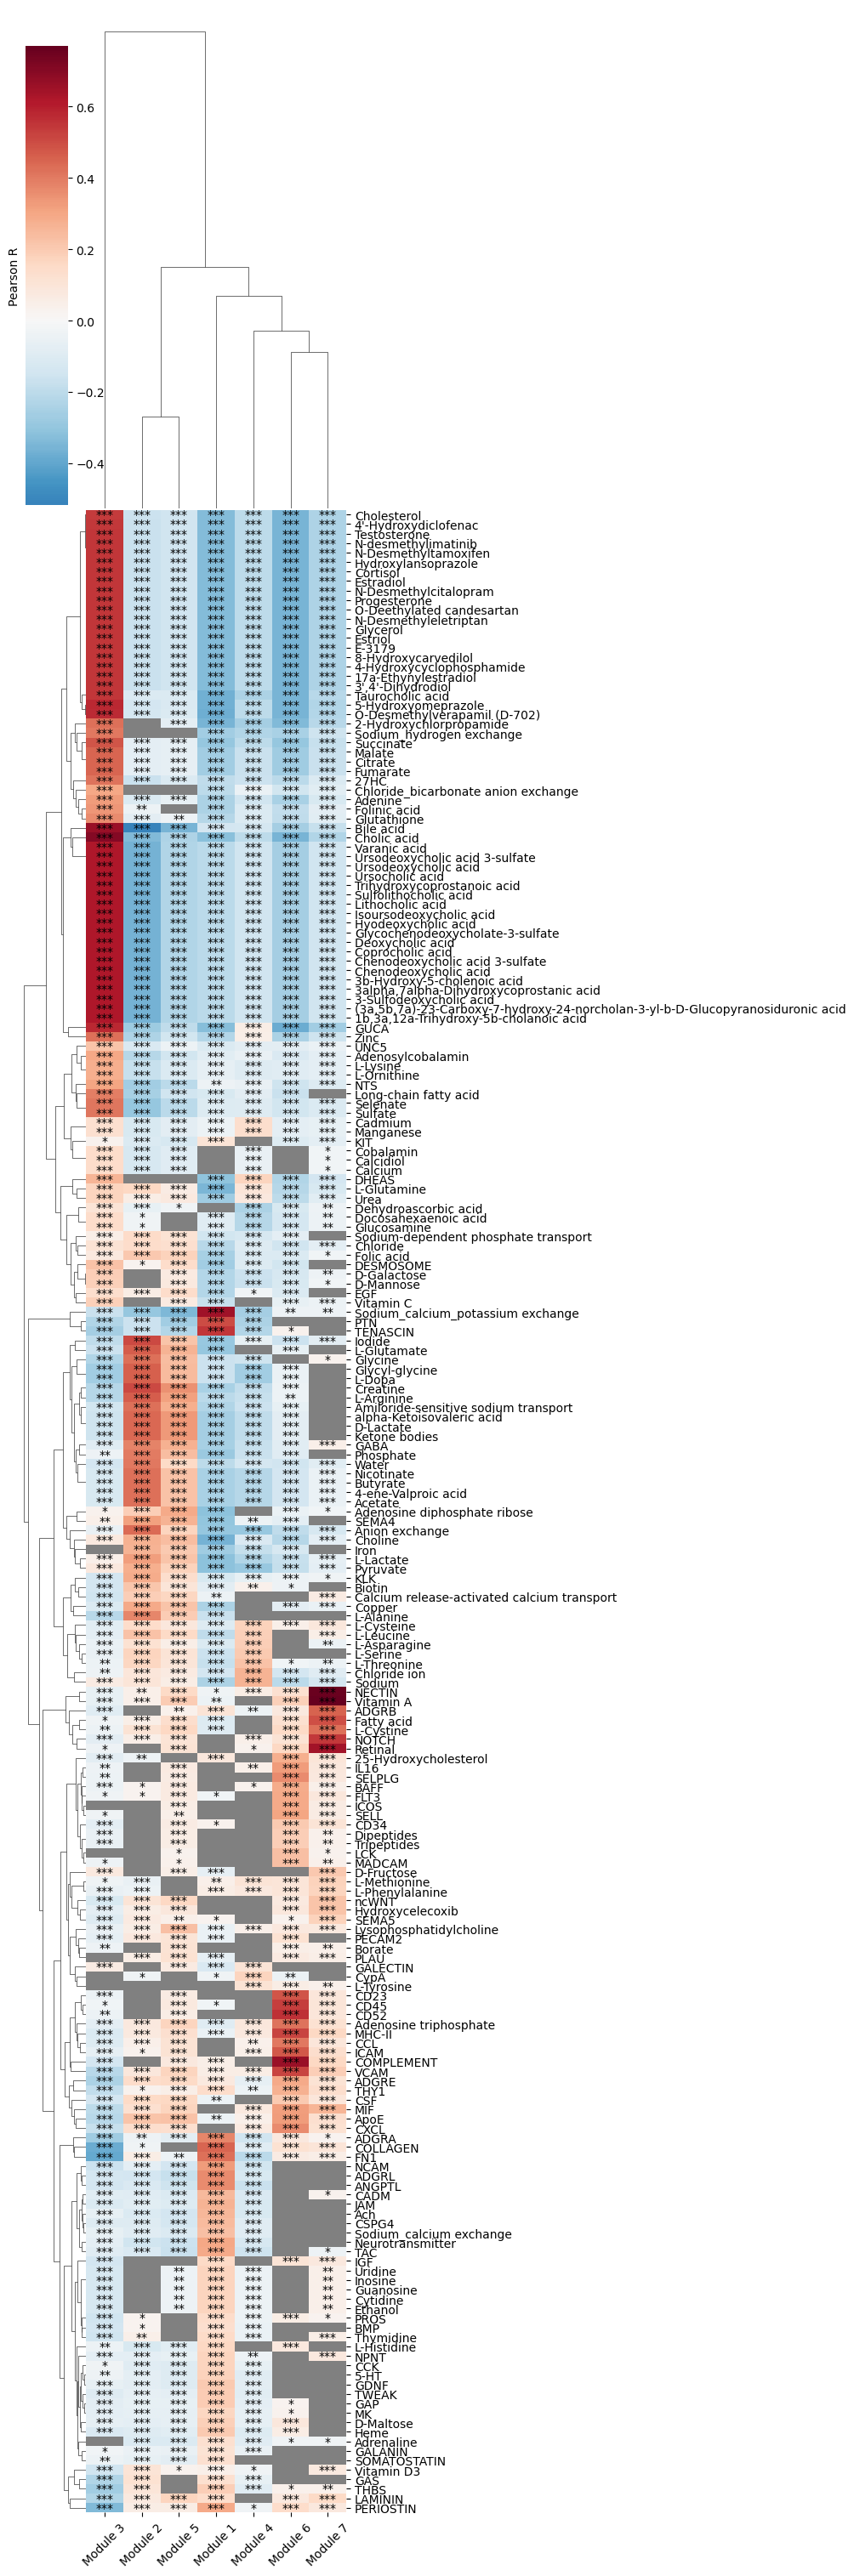

In [4]:
harreman.pl.plot_interaction_module_correlation(adata, x_rotation = 45, figsize = (10,30), threshold = 0.1)

In [4]:
metabolites = ['Sodium_calcium_potassium exchange', 'Creatine', 'Cholic acid', 'Adenosine triphosphate', 'Vitamin A', 'Lysophosphatidylcholine']

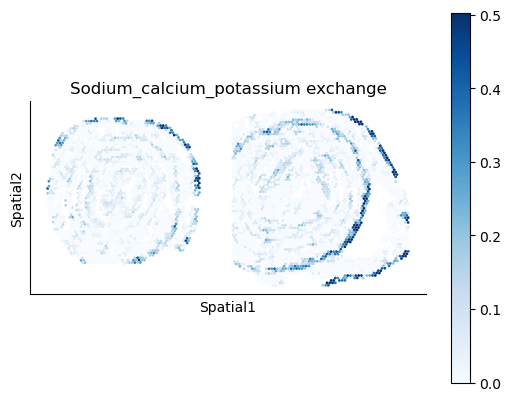

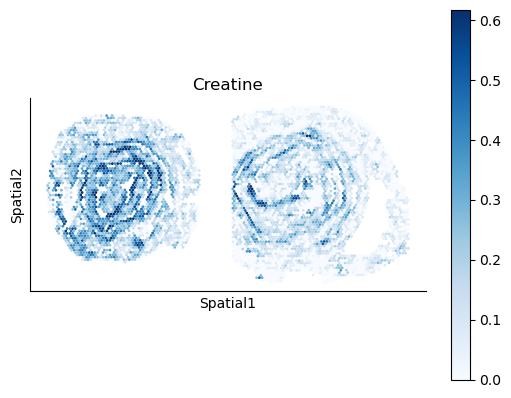

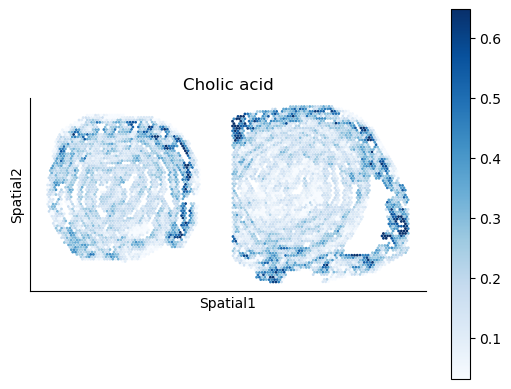

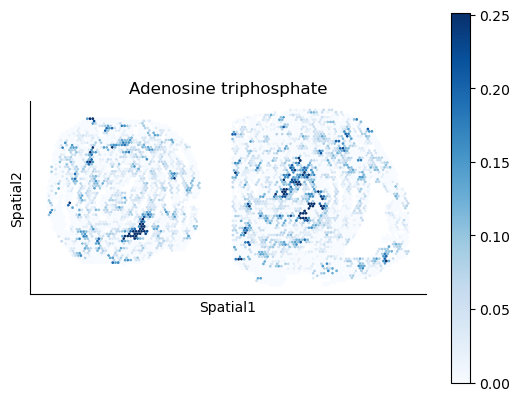

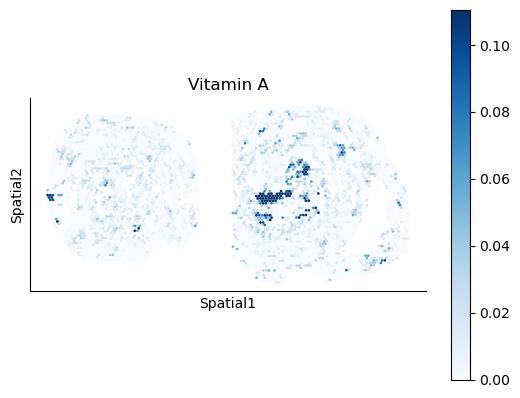

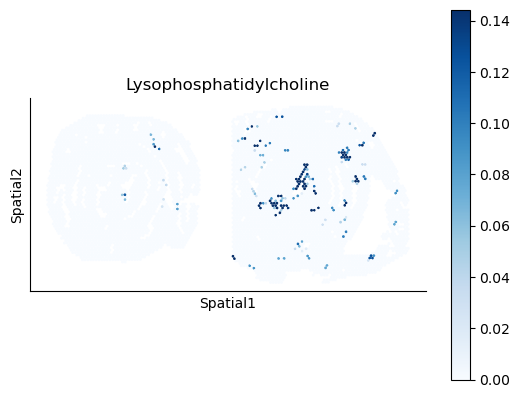

In [5]:
harreman.pl.plot_interacting_cell_scores(adata, interactions=metabolites, test='non-parametric', coords_obsm_key='spatial', s=1, vmin='p5', vmax='p99', only_sig_values=False, normalize_values=True, cmap='Blues', swap_y_axis=True)

In [15]:
interacting_cell_scores_gp = adata.uns['interacting_cell_results']['np']['gp']['cs']
interacting_cell_scores_m = adata.uns['interacting_cell_results']['np']['m']['cs']

interacting_cell_scores_gp = pd.DataFrame(interacting_cell_scores_gp, index=adata.obs_names, columns=adata.uns['gene_pairs_sig_names'])
interacting_cell_scores_m = pd.DataFrame(interacting_cell_scores_m, index=adata.obs_names, columns=adata.uns['metabolites'])
gene_pairs = [inter for inter in metabolites if inter in adata.uns['gene_pairs_sig_names']]
metabs = [inter for inter in metabolites if inter in adata.uns['metabolites']]
if len(gene_pairs) > 0 and len(metabs) > 0:
    interacting_cell_scores = pd.concat([interacting_cell_scores_gp, interacting_cell_scores_m], axis=1)
elif len(gene_pairs) == 0 and len(metabs) == 0:
    raise ValueError("The provided LR pairs and/or metabolites don't have significant interactions.")
else:
    interacting_cell_scores = interacting_cell_scores_gp if len(gene_pairs) > 0 else interacting_cell_scores_m

scores = interacting_cell_scores[metabolites]
scores = scores.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

In [16]:
violin_data = pd.concat([scores, adata.obs[['cond', 'top_super_module']]], axis=1).dropna()

In [17]:
violin_data_melt = pd.melt(violin_data, id_vars=['cond', 'top_super_module'], value_vars=metabolites)

In [18]:
cond_palette = {
    'Day 0': '#ffbb78',
    'Day 14': '#c5b0d5',
}

In [19]:
violin_data_melt['cond'] = violin_data_melt['cond'].astype('category')
violin_data_melt['variable'] = violin_data_melt['variable'].astype('category')

In [20]:
violin_data_melt['variable'] = violin_data_melt['variable'].astype('category')
violin_data_melt['variable'] = violin_data_melt['variable'].cat.reorder_categories(metabolites)

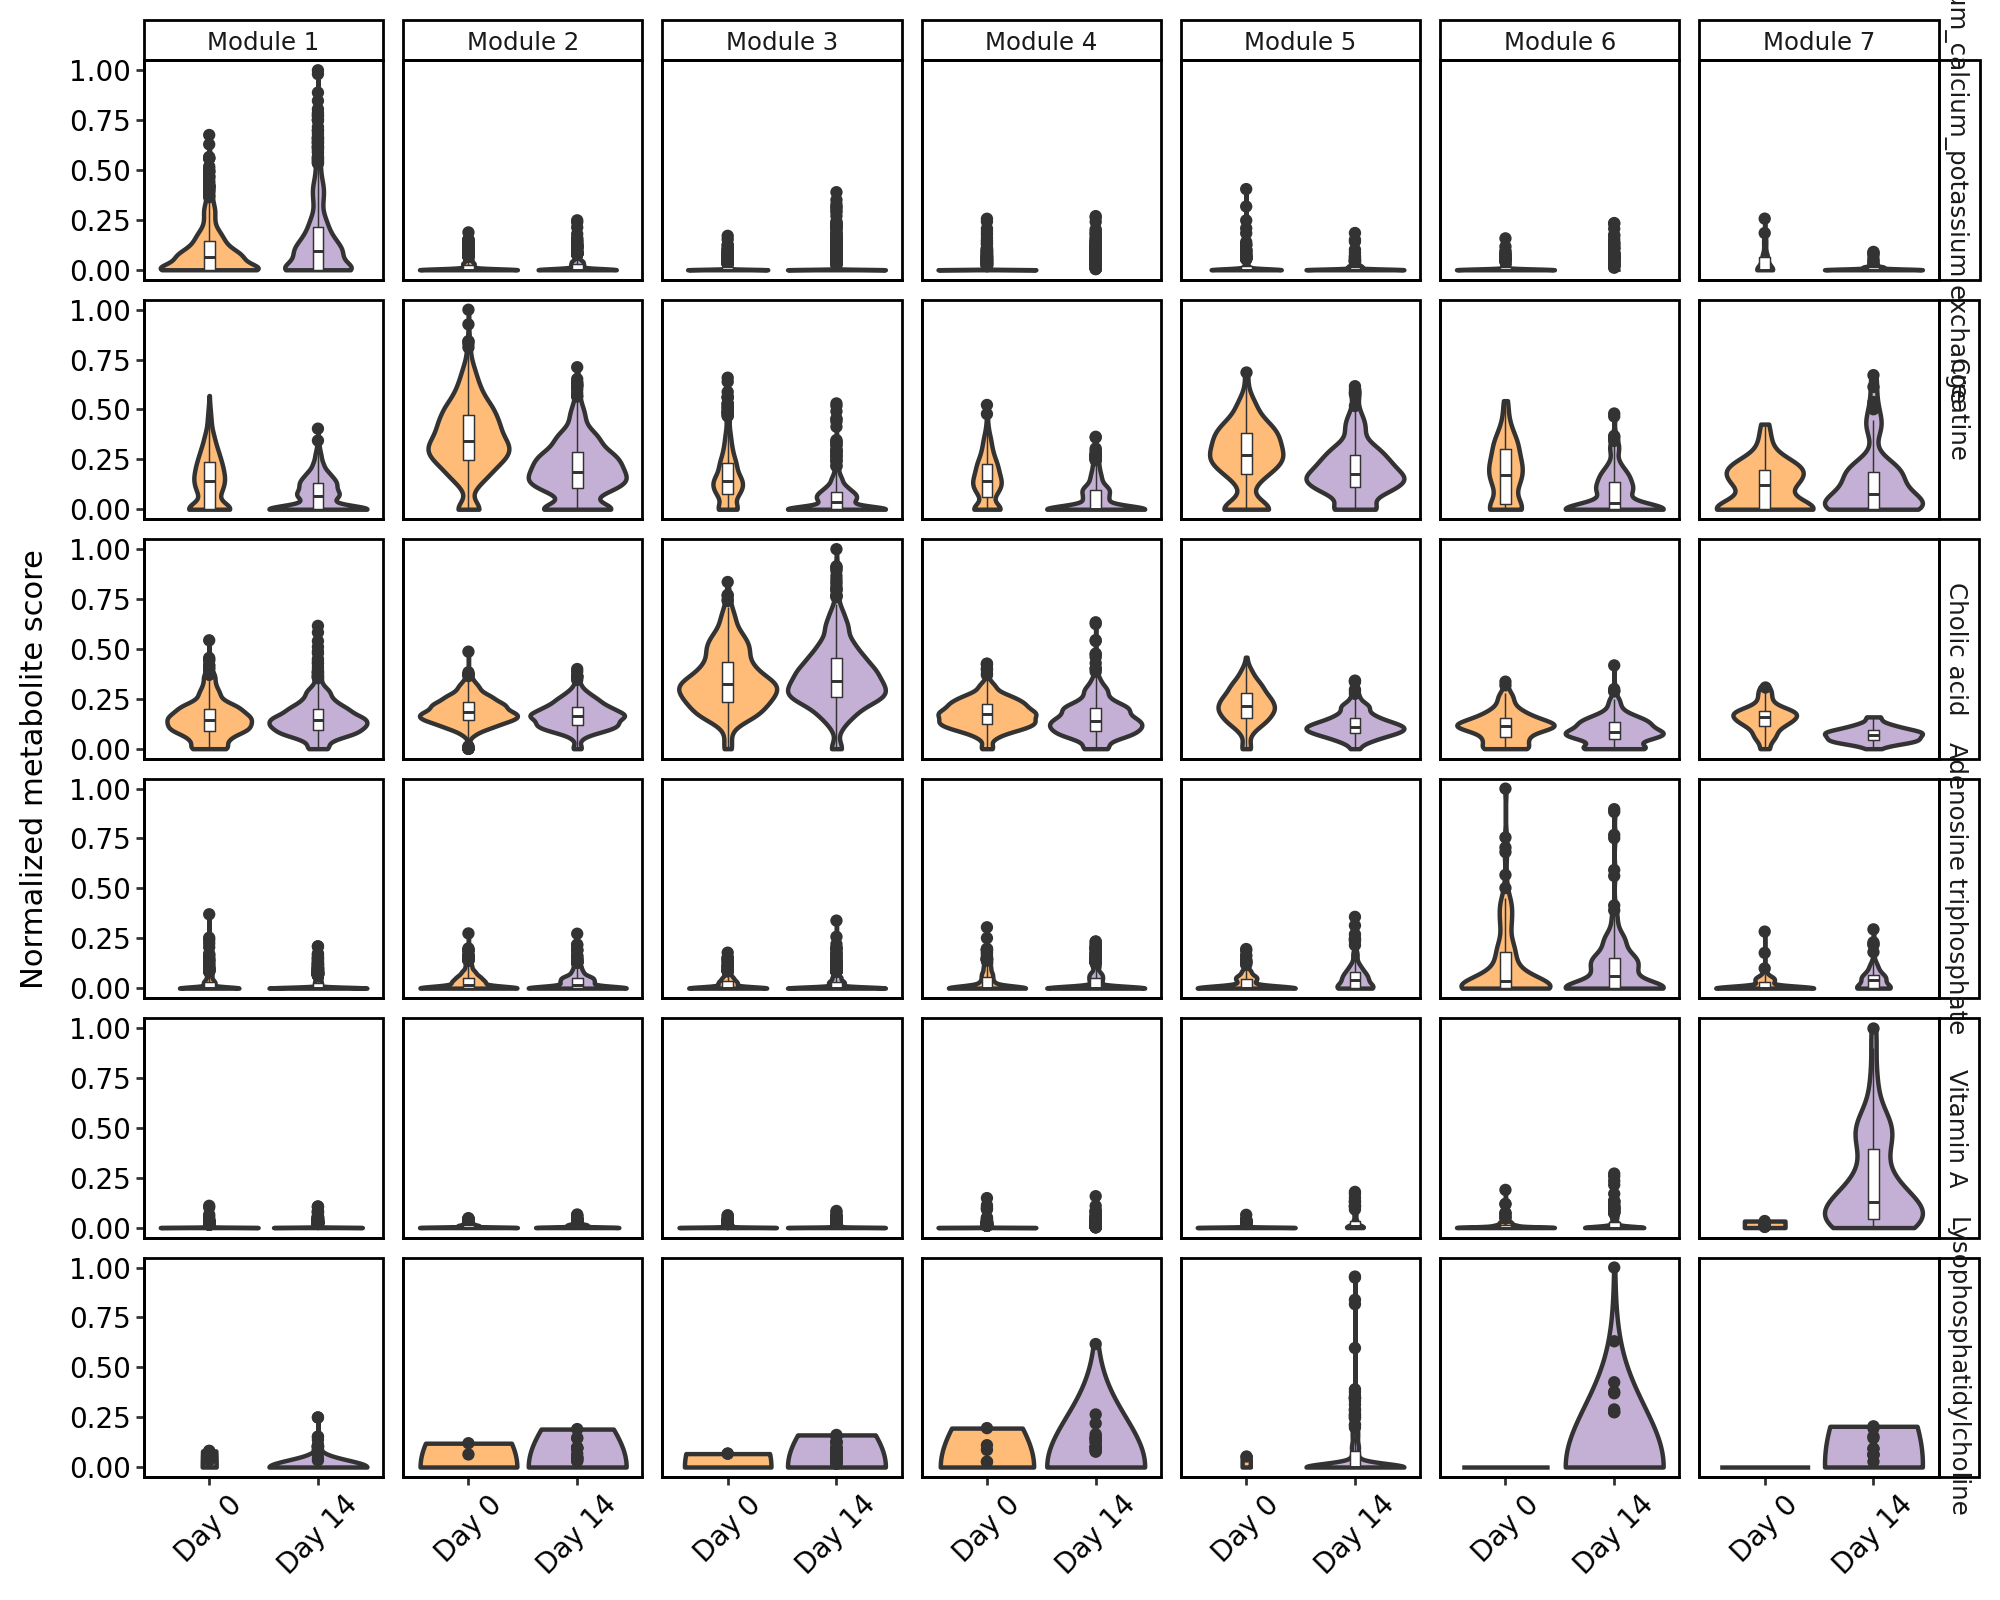

In [21]:
fig = (
ggplot(data=violin_data_melt, mapping=aes(x='cond', y='value', fill='cond')) 
+ geom_violin(size=0.9)
+ geom_boxplot(width=0.1, fill='white', size=0.3)
+ facet_grid(rows='variable', cols='top_super_module')
+ scale_fill_manual(values=cond_palette)
# + xlab('')
+ ylab('Normalized metabolite score')
+ theme_classic() 
+ theme(plot_title = element_text(hjust = 0.5,
                                margin={"t": 0, "b": 5, "l": 0, "r": 0},
                                size = 14,
                                face='bold'),
        legend_position = "none",
        axis_title_x = element_blank(),
        axis_title_y = element_text(size = 11),
        axis_text_x = element_text(margin={"t": 0, "b": 0, "l": 0, "r": 10}, size = 10, colour='black', rotation=45),
        axis_text_y = element_text(margin={"t": 0, "b": 0, "l": 0, "r": 10}, size = 10, colour='black'),
        panel_border = element_rect(color='black'),
        panel_background = element_rect(colour = "black",
                                        linewidth = 1),
        figure_size=(10, 8))
)
fig.show()
# fig.save(os.path.join(PLOTS_PATH, 'metab_score_violin_plot.svg'), format='svg')

In [27]:
cell_communication_df = adata.uns['ccc_results']['cell_com_df_gp_sig'].copy()

In [24]:
gene_pairs_per_metabolite = adata.uns['gene_pairs_per_metabolite']
    
def to_tuple(x):
    # Recursively convert lists to tuples
    if isinstance(x, list):
        return tuple(to_tuple(i) for i in x)
    return x

metabolite_gene_pair_df = pd.DataFrame.from_dict(gene_pairs_per_metabolite, orient="index").reset_index()
metabolite_gene_pair_df = metabolite_gene_pair_df.rename(columns={"index": "metabolite"})
metabolite_gene_pair_df['gene_pair'] = metabolite_gene_pair_df['gene_pair'].apply(
    lambda arr: [(to_tuple(gp[0]), to_tuple(gp[1])) for gp in arr]
)
metabolite_gene_pair_df['gene_type'] = metabolite_gene_pair_df['gene_type'].apply(
    lambda arr: [(to_tuple(gt[0]), to_tuple(gt[1])) for gt in arr]
)
metabolite_gene_pair_df = pd.concat([
    metabolite_gene_pair_df['metabolite'],
    metabolite_gene_pair_df.explode('gene_pair')['gene_pair'],
    metabolite_gene_pair_df.explode('gene_type')['gene_type'],
], axis=1).reset_index(drop=True)

if 'LR_database' in adata.uns:
    LR_database = adata.uns['LR_database']
    df_merged = pd.merge(metabolite_gene_pair_df, LR_database, left_on='metabolite', right_on='interaction.name', how='left')
    LR_df = df_merged.dropna(subset=['pathway.name'])
    metabolite_gene_pair_df['metabolite'][metabolite_gene_pair_df.metabolite.isin(LR_df.metabolite)] = LR_df['pathway.name']

In [25]:
metabolite_gene_pair_df = metabolite_gene_pair_df.set_index('metabolite')

In [28]:
def is_present(row, gene_pairs):
    gene1, gene2 = row['Gene 1'], row['Gene 2']
    return any(
        (gene1 in pair and gene2 in pair) if isinstance(pair, tuple) else False
        for pair in gene_pairs
    )

gene_pairs = metabolite_gene_pair_df.loc[metabolites]['gene_pair'].tolist()
cell_communication_df_filt = cell_communication_df[cell_communication_df.apply(lambda row: is_present(row, gene_pairs), axis=1)]

In [29]:
gene_pairs_filt = list(zip(cell_communication_df_filt["Gene 1"], cell_communication_df_filt["Gene 2"]))

In [31]:
gene_1 = ["_".join(pair[0]) if isinstance(pair[0], list) else pair[0] for pair in gene_pairs]
gene_2 = ["_".join(pair[1]) if isinstance(pair[1], list) else pair[1] for pair in gene_pairs]

def remove_duplicates(lst):
    seen = set()
    return [x for x in lst if not (x in seen or seen.add(x))]

gene_1 = remove_duplicates(gene_1)
gene_2 = remove_duplicates(gene_2)

In [33]:
cell_communication_df_filt['log10_FDR'] = -np.log10(cell_communication_df_filt['FDR_np'])
cell_communication_df_filt['log10_C'] = np.log10(cell_communication_df_filt['C_np'])

In [34]:
def convert_list_to_string(value):
    return '_'.join(value) if isinstance(value, list) else value

# Apply conversion to both columns
cell_communication_df_filt['Gene 1'] = cell_communication_df_filt['Gene 1'].apply(convert_list_to_string)
cell_communication_df_filt['Gene 2'] = cell_communication_df_filt['Gene 2'].apply(convert_list_to_string)

In [36]:
gene_1 = [gene for gene in gene_1 if gene in cell_communication_df_filt['Gene 1'].unique()]
gene_2 = [gene for gene in gene_2 if gene in cell_communication_df_filt['Gene 2'].unique()]

In [39]:
cell_communication_df_filt['Gene 1'] = cell_communication_df_filt['Gene 1'].astype('category')
cell_communication_df_filt['Gene 1'] = cell_communication_df_filt['Gene 1'].cat.reorder_categories(gene_1[::-1])

cell_communication_df_filt['Gene 2'] = cell_communication_df_filt['Gene 2'].astype('category')
cell_communication_df_filt['Gene 2'] = cell_communication_df_filt['Gene 2'].cat.reorder_categories(gene_2)

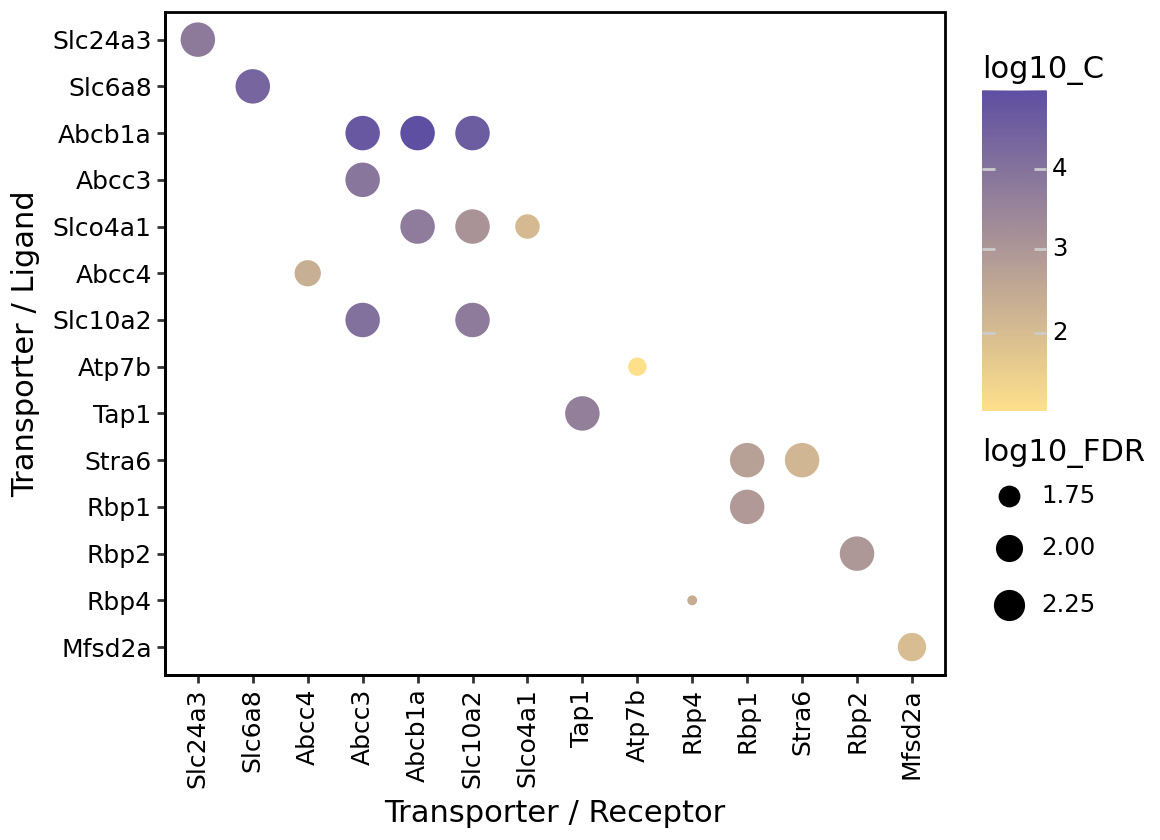

In [41]:
fig = (
ggplot(data=cell_communication_df_filt, mapping=aes(x='Gene 2', y='Gene 1', color='log10_C', size='log10_FDR')) 
+ geom_point()
+ scale_color_gradient(low = "#FEE08B", high = "#5E4FA2")
+ theme_classic() 
+ theme(plot_title = element_text(hjust = 0.5,
                                margin={"t": 0, "b": 5, "l": 0, "r": 0},
                                size = 14,
                                face='bold'),
        # legend_position = "none",
        axis_title_x = element_text(size = 11),
        axis_title_y = element_text(size = 11),
        axis_text_x = element_text(margin={"t": 0, "b": 0, "l": 0, "r": 10}, size = 9, colour='black', rotation=90),
        axis_text_y = element_text(margin={"t": 0, "b": 0, "l": 0, "r": 10}, size = 9, colour='black'),
        panel_border = element_rect(color='black'),
        panel_background = element_rect(colour = "black",
                                        linewidth = 1),
        figure_size=(5.8, 4.2)) + ylab('Transporter / Ligand') + xlab('Transporter / Receptor')
)
fig.show()
# fig.save(os.path.join(PLOTS_PATH, 'gene_pair_dot_plot.svg'), format='svg')

#### Metabolite modules

In [2]:
adata = harreman.read_h5ad(os.path.join(ADATA_PATH, 'Visium_colon_Harreman_unrolled.h5ad'))

In [3]:
interacting_cell_scores_m = adata.uns['interacting_cell_results']['np']['m']['cs'].copy()
n=1
means = np.nanmean(interacting_cell_scores_m, axis=0)
stds = np.nanstd(interacting_cell_scores_m, axis=0)
thresholds = means + n*stds
interacting_cell_scores_m[interacting_cell_scores_m < thresholds] = 0

In [4]:
interacting_cell_scores_m = pd.DataFrame(interacting_cell_scores_m, index=adata.obs_names, columns=adata.uns['metabolites'])

In [5]:
interacting_cell_scores_m[interacting_cell_scores_m != 0] = 1

In [18]:
metabolites = ['Sodium_calcium_potassium exchange', 'Creatine', 'Cholic acid', 'Adenosine triphosphate', 'Vitamin A', 'Lysophosphatidylcholine']

In [19]:
for metab in metabolites:
    adata.obs[metab] = interacting_cell_scores_m[metab].astype('category')

In [6]:
metab_scores_adata = ad.AnnData(interacting_cell_scores_m)
metab_scores_adata.obs_names = adata.obs_names
metab_scores_adata.var_names = adata.uns['metabolites']

metab_scores_adata.obs['cond'] = adata.obs['cond']
metab_scores_adata.obsm['spatial_unrolled'] = adata.obsm['spatial_unrolled']
metab_scores_adata.obsm['spatial'] = adata.obsm['spatial']

In [7]:
harreman.tl.compute_knn_graph(metab_scores_adata, 
                           compute_neighbors_on_key="spatial_unrolled", 
                           n_neighbors=5,
                           weighted_graph=False,
                           sample_key='cond')

100%|██████████| 2/2 [00:00<00:00, 102.20it/s]


The code below is only ran to filter out metabolites with all-zero values in at least one of the samples for subsequent pairwise correlation. We don't select autocorrelated metabolites through this approach as they have already been selected in a different manner.

In [8]:
harreman.hs.compute_local_autocorrelation(metab_scores_adata, model='bernoulli')

In [14]:
gene_autocorrelation_results = metab_scores_adata.uns['gene_autocorrelation_results']
metabolites = gene_autocorrelation_results.index

In [29]:
harreman.hs.compute_local_correlation(metab_scores_adata, genes=metabolites, verbose=True)

Computing pair-wise local correlation on 234 features...
Pair-wise local correlation results are stored in adata.uns with the following keys: ['lcs', 'lc_zs', 'lc_z_pvals', 'lc_z_FDR']
Finished computing pair-wise local correlation in 1.035 seconds


In [30]:
harreman.hs.create_modules(metab_scores_adata, min_gene_threshold=9)

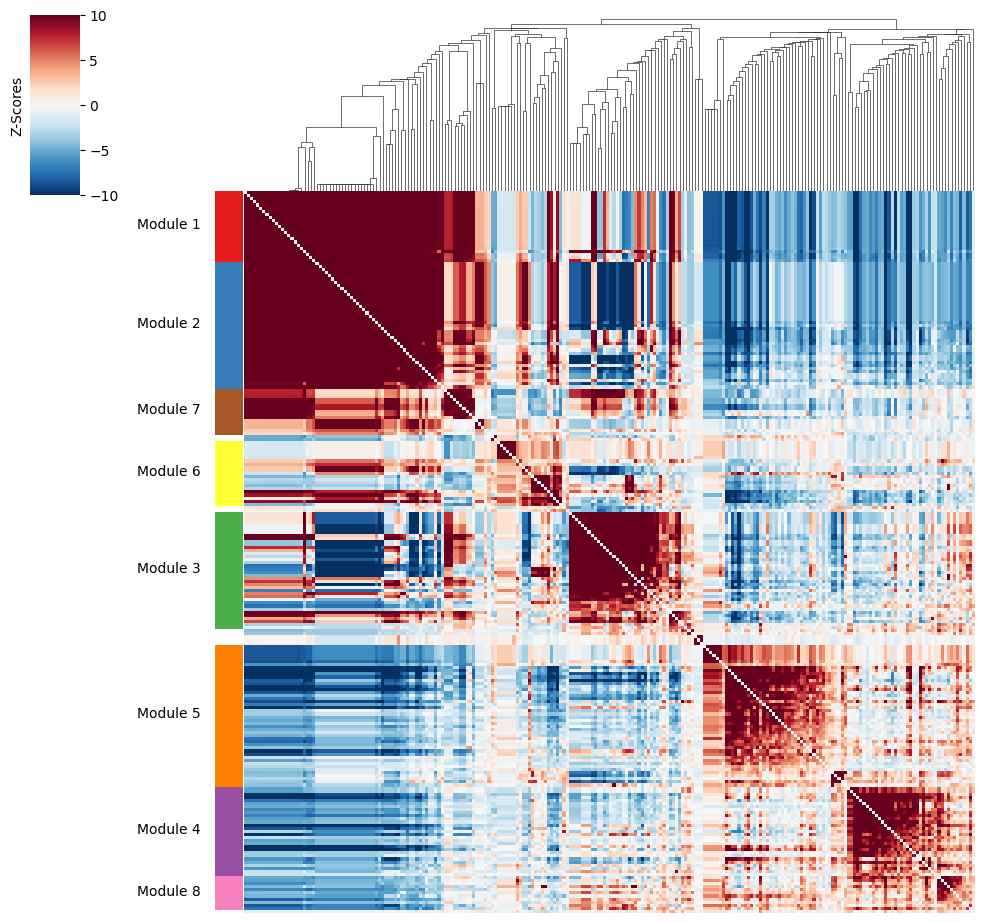

In [31]:
harreman.pl.local_correlation_plot(metab_scores_adata, mod_cmap='Set1')

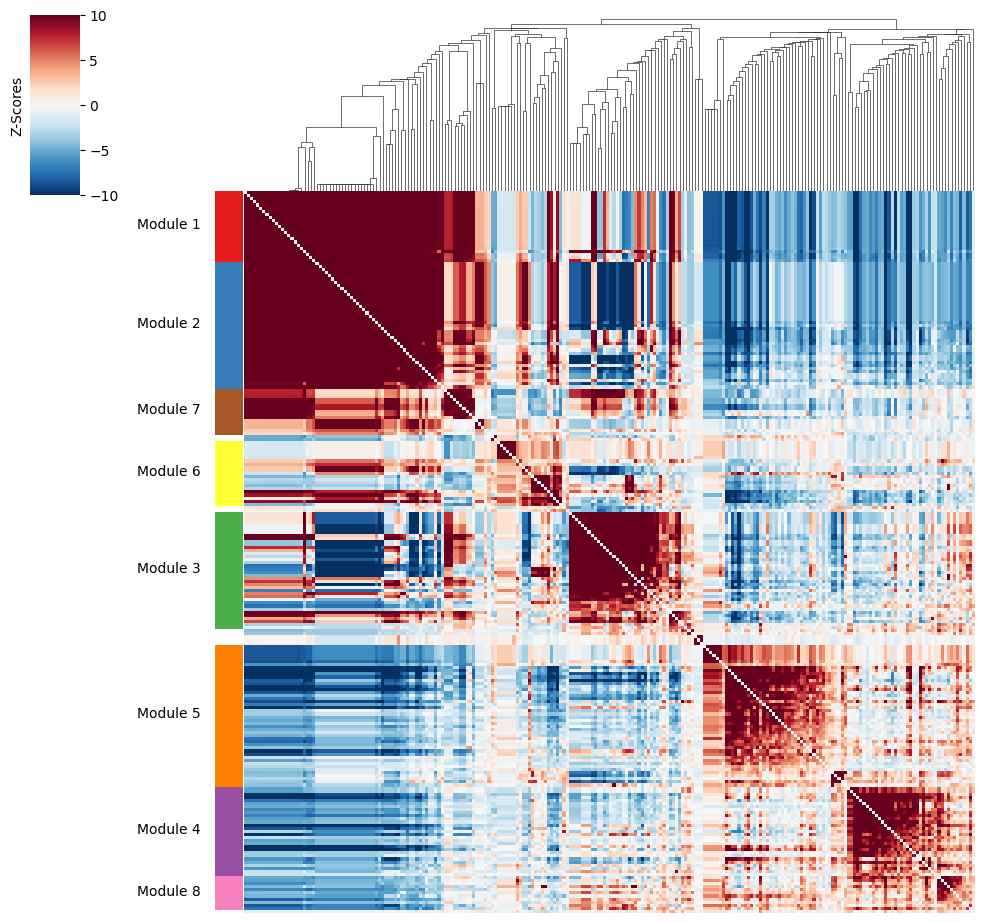

In [14]:
harreman.pl.local_correlation_plot(metab_scores_adata, mod_cmap='Set1')

In [32]:
harreman.hs.calculate_module_scores(metab_scores_adata)

100%|██████████| 8/8 [00:00<00:00, 22.48it/s]


In [33]:
modules = metab_scores_adata.obsm['module_scores'].columns
metab_scores_adata.obs[modules] = metab_scores_adata.obsm['module_scores']

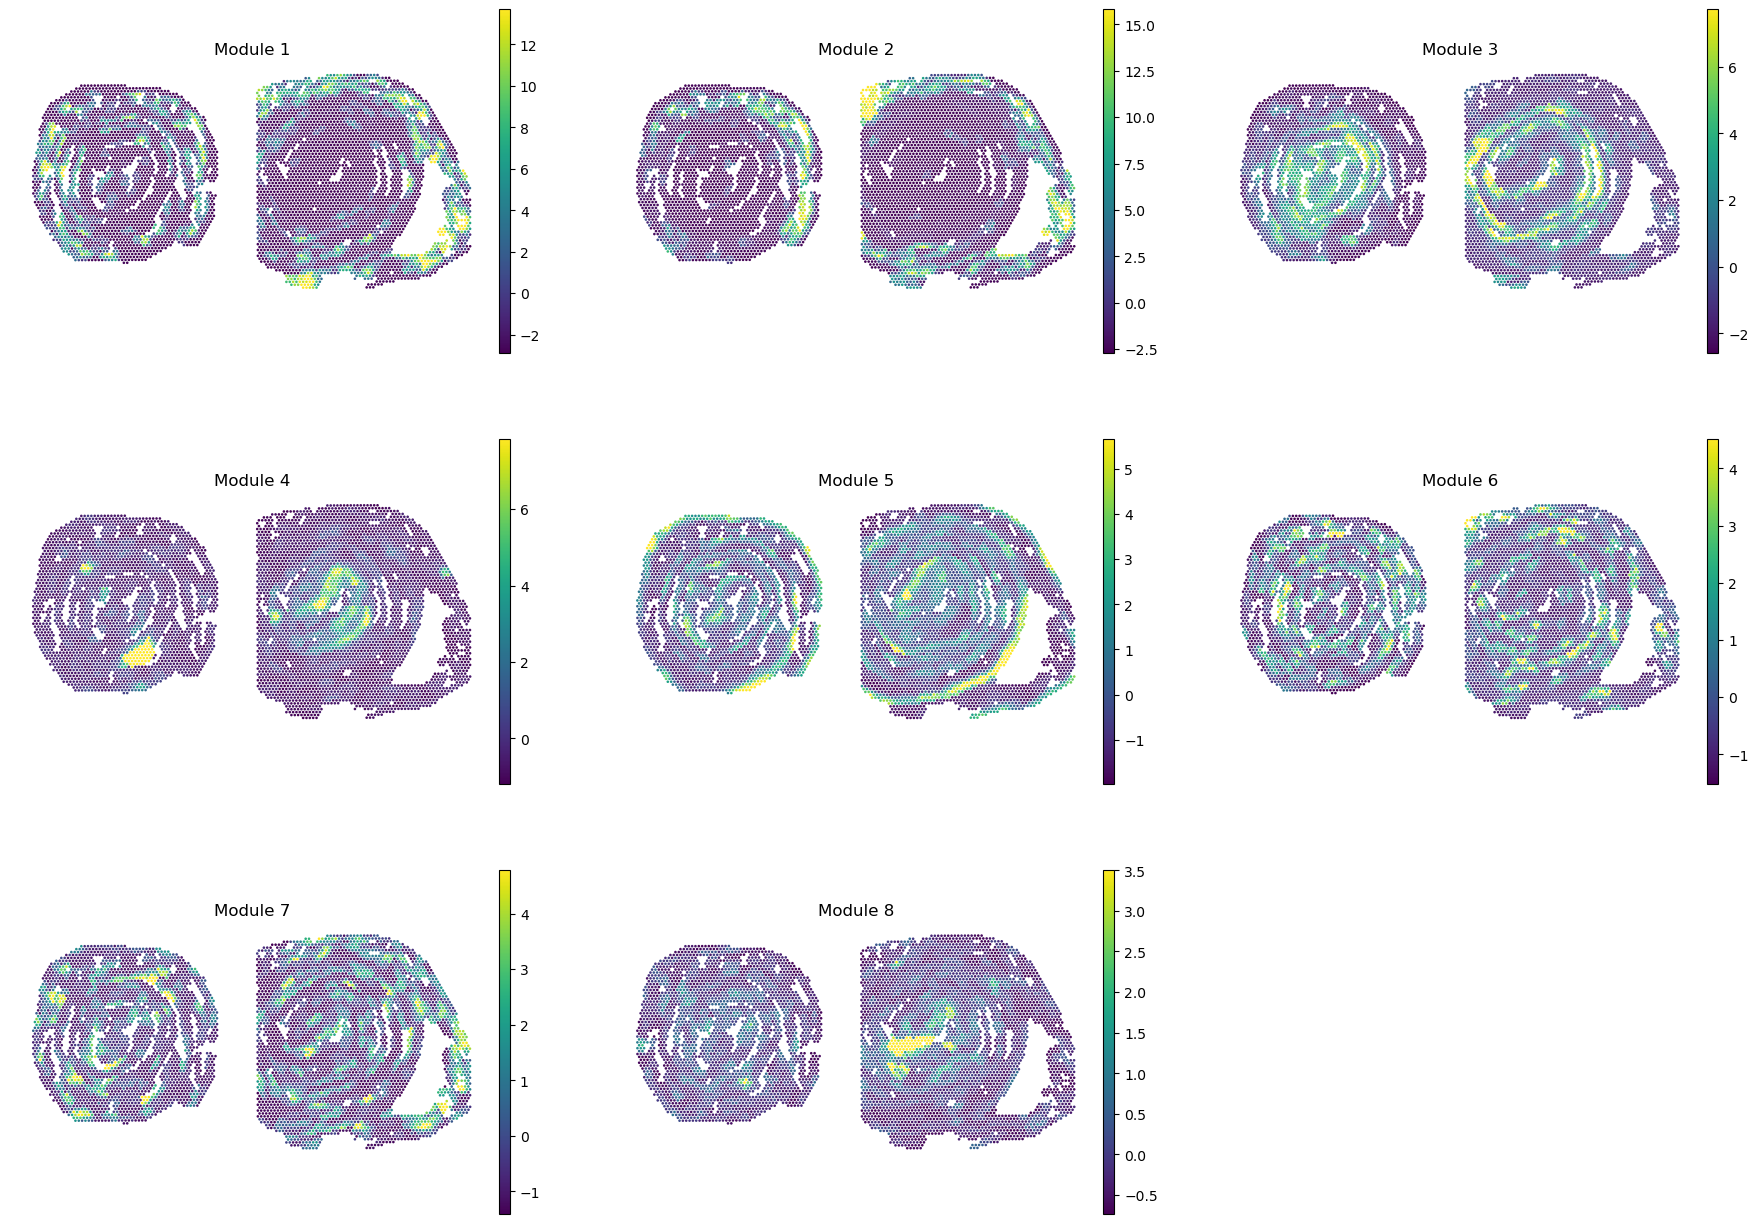

In [35]:
sc.pl.spatial(metab_scores_adata, color=modules, spot_size=80, frameon=False, vmin="p1", vmax="p99", ncols=3, cmap='viridis')

In [36]:
super_module_dict = {
    -1: [6],
    1: [1, 2, 7],
    2: [3],
    3: [4],
    4: [5],
    5: [8],
}

In [37]:
harreman.hs.calculate_super_module_scores(metab_scores_adata, super_module_dict=super_module_dict)

100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

Finished computing super-module scores in 0.414 seconds


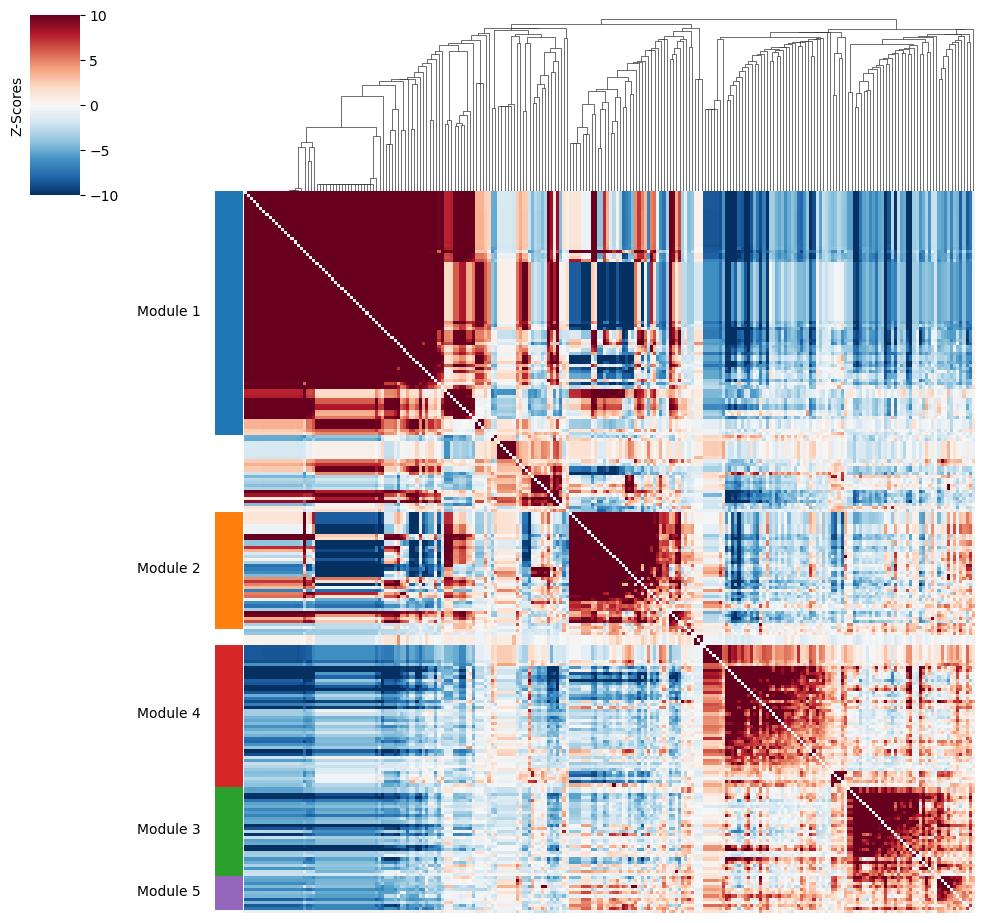

In [40]:
harreman.pl.local_correlation_plot(metab_scores_adata, use_super_modules=True, show=True)

In [41]:
super_modules = metab_scores_adata.obsm['super_module_scores'].columns
metab_scores_adata.obs[super_modules] = metab_scores_adata.obsm['super_module_scores']

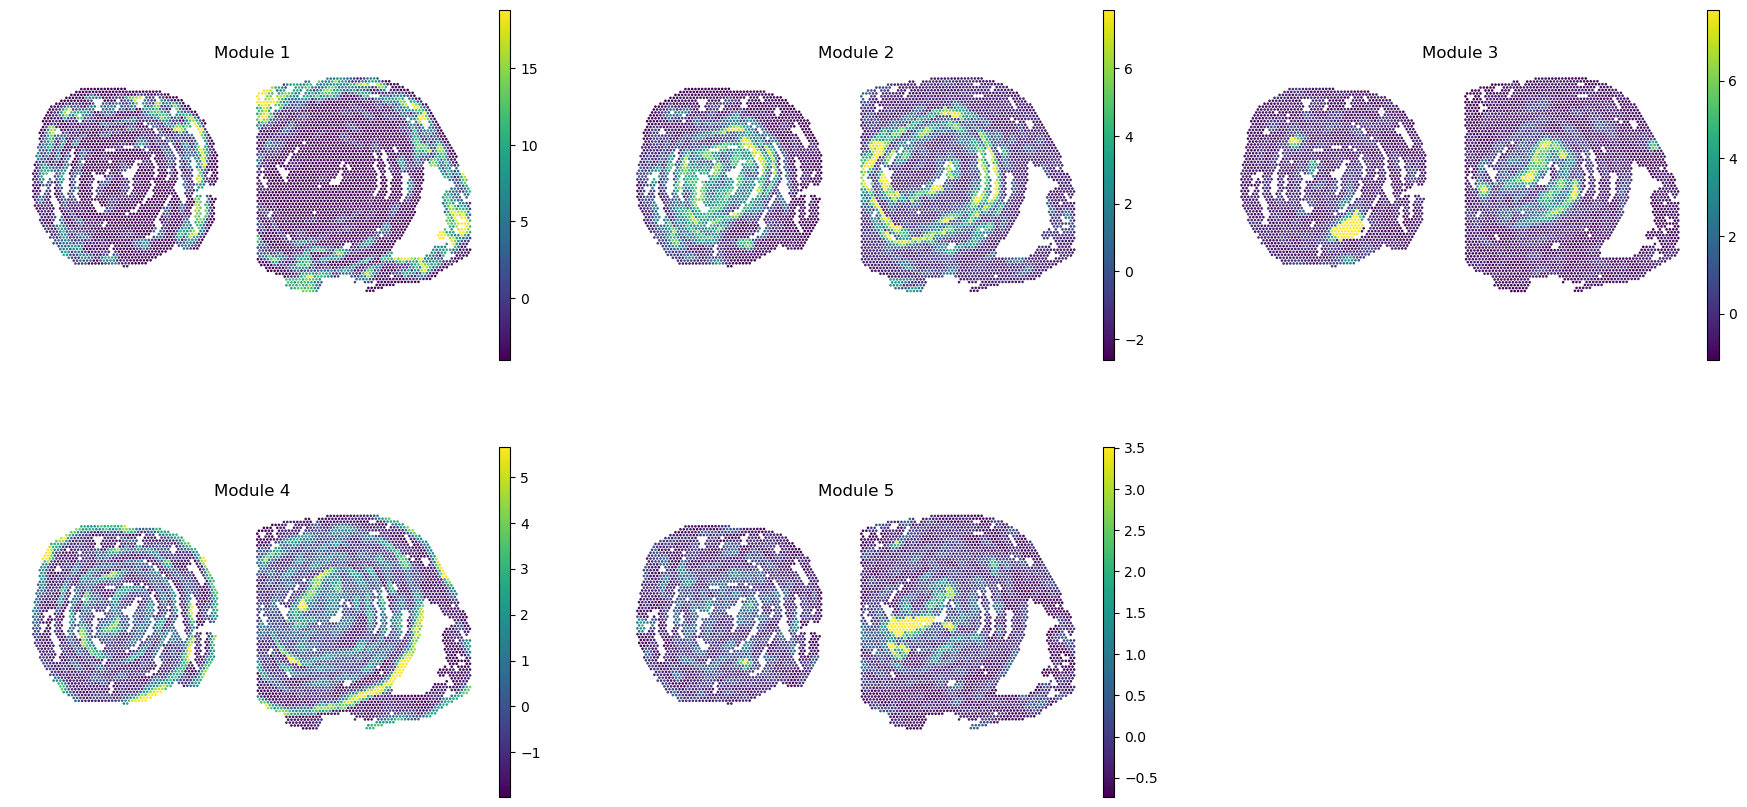

In [42]:
sc.pl.spatial(metab_scores_adata, color=super_modules, spot_size=80, frameon=False, vmin="p1", vmax="p99", ncols=3, cmap='viridis')

In [2]:
metab_modules_dict=pd.read_excel(os.path.join(DATA_PATH, "Visium_colon_metab_module_metab_list.xlsx"), index_col=0, sheet_name=None)

In [6]:
TRANSPORTER_DB_PATH = '/home/projects/nyosef/oier/Harreman/data/HarremanDB/HarremanDB_mouse_extracellular.csv'
transporter_db_df = pd.read_csv(TRANSPORTER_DB_PATH, index_col=0)

In [7]:
all_metabolites = transporter_db_df['Metabolite'].tolist()

In [8]:
all_metabolites = [metab.replace('/', '_') for metab in all_metabolites]

In [47]:
metabs_to_label = ["Cholic acid", "Taurocholic acid", "Succinate", "Fumarate", "Zinc",
                   "Creatine", "Butyrate", "L-Lactate", "Pyruvate", "L-Arginine",
                   'Adenosine triphosphate', "Tripeptides", "Dipeptides",
                   'Sodium_calcium_potassium exchange',
                   'Retinal', 'Lysophosphatidylcholine', 'Vitamin A']

In [48]:
module_colors = {
    1: "#FC9272",
    2: "#DFC27D",
    3: "#80CDC1",
    4: "#ABDDA4",
    5: "#F1B6DA",
}

In [49]:
from scipy.cluster.hierarchy import leaves_list

In [50]:
vmin=-10
vmax=10
z_cmap='RdBu_r'
yticklabels=False
use_super_modules=True
row_colors=True,
col_colors=None,

local_correlation_z = metab_scores_adata.uns["lc_zs"]
modules = metab_scores_adata.uns["super_modules"] if use_super_modules else metab_scores_adata.uns["modules"]
linkage = metab_scores_adata.uns["linkage"]

row_colors = None
module_colors[-1] = '#ffffff'

row_colors1 = pd.Series(
    [module_colors[i] for i in modules],
    index=local_correlation_z.index,
)

row_colors = pd.DataFrame({
    "Modules": row_colors1,
})

col_colors = row_colors if col_colors is True else None

cm = sns.clustermap(
    local_correlation_z,
    row_linkage=linkage,
    col_linkage=linkage,
    vmin=vmin,
    vmax=vmax,
    cmap=z_cmap,
    xticklabels=False,
    yticklabels=yticklabels,
    row_colors=row_colors,
    col_colors=row_colors,
    rasterized=True,
)

fig = plt.gcf()
plt.sca(cm.ax_heatmap)
plt.ylabel("")
plt.xlabel("")

cm.ax_row_dendrogram.remove()
cm.ax_col_dendrogram.remove()
# Add 'module X' annotations
ii = leaves_list(linkage)

mod_reordered = modules.iloc[ii]

adata.uns['mod_reordered'] = [mod for mod in mod_reordered.unique() if mod != -1]

mod_map = {}
y = np.arange(modules.size)

for x in mod_reordered.unique():
    if x == -1:
        continue

    mod_map[x] = y[mod_reordered == x].mean()

plt.sca(cm.ax_row_colors)
for mod, mod_y in mod_map.items():
    plt.text(-.5, y=mod_y, s="Module {}".format(mod),
                horizontalalignment='right',
                verticalalignment='center')
plt.xticks([])

# Find the colorbar 'child' and modify
min_delta = 1e99
min_aa = None
for aa in fig.get_children():
    try:
        bbox = aa.get_position()
        delta = (0-bbox.xmin)**2 + (1-bbox.ymax)**2
        if delta < min_delta:
            delta = min_delta
            min_aa = aa
    except AttributeError:
        pass

min_aa.set_ylabel('Z-Scores')
min_aa.yaxis.set_label_position("left")

# plt.savefig(os.path.join(PLOTS_PATH, 'metab_scores_local_correlation_plot.pdf'))

In [51]:
reordered_labels = local_correlation_z.index[cm.dendrogram_row.reordered_ind].tolist()
metabs_to_label = [metab for metab in reordered_labels if metab in metabs_to_label]
use_ticks = [reordered_labels.index(label) + 0.5 for label in metabs_to_label]

In [52]:
print('\n'.join(metabs_to_label))

Taurocholic acid
Cholic acid
Fumarate
Succinate
Zinc
Butyrate
Pyruvate
L-Lactate
Creatine
L-Arginine
Lysophosphatidylcholine
Sodium_calcium_potassium exchange
Dipeptides
Tripeptides
Adenosine triphosphate
Vitamin A
Retinal


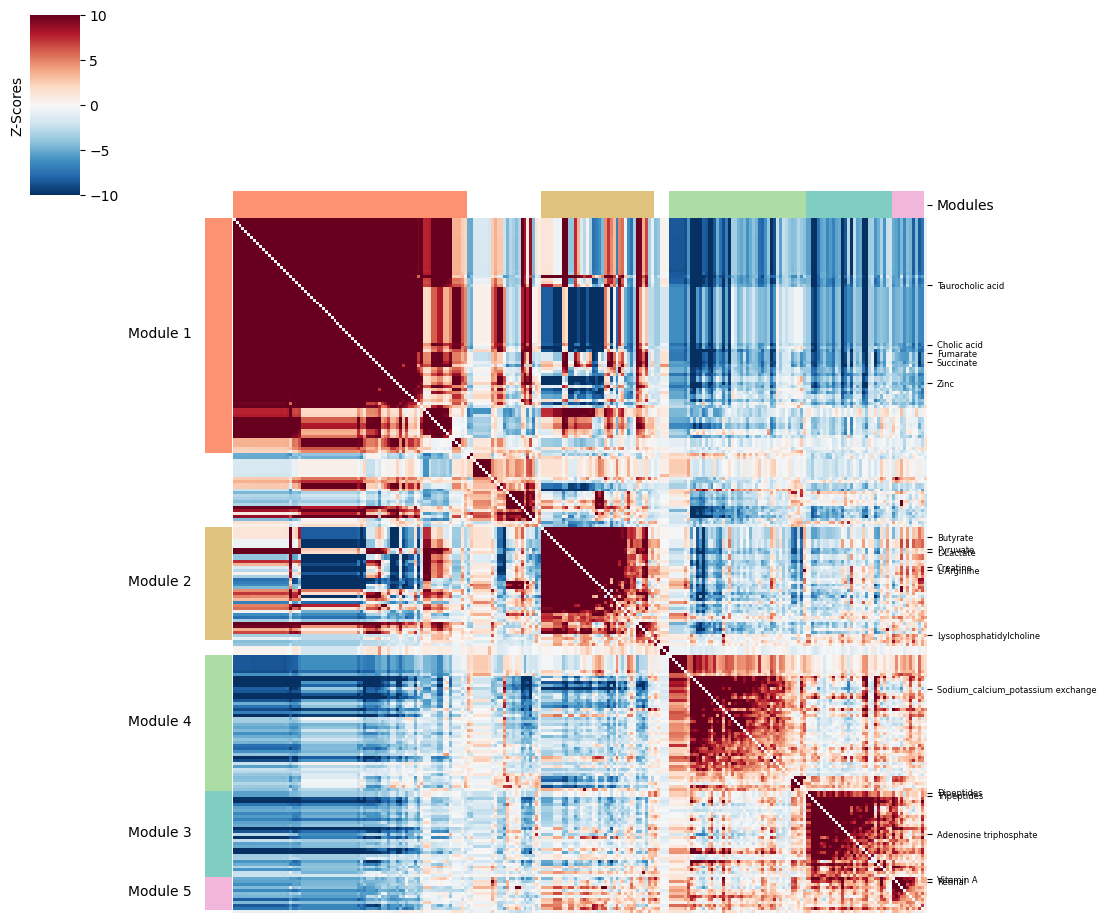

In [55]:
vmin=-10
vmax=10
z_cmap='RdBu_r'
yticklabels=False
use_super_modules=True
row_colors=True,
col_colors=None,

local_correlation_z = metab_scores_adata.uns["lc_zs"]
modules = metab_scores_adata.uns["super_modules"] if use_super_modules else metab_scores_adata.uns["modules"]
linkage = metab_scores_adata.uns["linkage"]

row_colors = None
module_colors[-1] = '#ffffff'

row_colors1 = pd.Series(
    [module_colors[i] for i in modules],
    index=local_correlation_z.index,
)

row_colors = pd.DataFrame({
    "Modules": row_colors1,
})

col_colors = row_colors if col_colors is True else None

cm = sns.clustermap(
    local_correlation_z,
    row_linkage=linkage,
    col_linkage=linkage,
    vmin=vmin,
    vmax=vmax,
    cmap=z_cmap,
    xticklabels=False,
    yticklabels=yticklabels,
    row_colors=row_colors,
    col_colors=row_colors,
    rasterized=True,
)

fig = plt.gcf()
plt.sca(cm.ax_heatmap)
plt.yticks(ticks=use_ticks, labels=metabs_to_label, size=6)
plt.ylabel("")
plt.xlabel("")

cm.ax_row_dendrogram.remove()
cm.ax_col_dendrogram.remove()
# Add 'module X' annotations
ii = leaves_list(linkage)

mod_reordered = modules.iloc[ii]

adata.uns['mod_reordered'] = [mod for mod in mod_reordered.unique() if mod != -1]

mod_map = {}
y = np.arange(modules.size)

for x in mod_reordered.unique():
    if x == -1:
        continue

    mod_map[x] = y[mod_reordered == x].mean()

plt.sca(cm.ax_row_colors)
for mod, mod_y in mod_map.items():
    plt.text(-.5, y=mod_y, s="Module {}".format(mod),
                horizontalalignment='right',
                verticalalignment='center')
plt.xticks([])

# Find the colorbar 'child' and modify
min_delta = 1e99
min_aa = None
for aa in fig.get_children():
    try:
        bbox = aa.get_position()
        delta = (0-bbox.xmin)**2 + (1-bbox.ymax)**2
        if delta < min_delta:
            delta = min_delta
            min_aa = aa
    except AttributeError:
        pass

min_aa.set_ylabel('Z-Scores')
min_aa.yaxis.set_label_position("left")

plt.show()

# plt.savefig(os.path.join(PLOTS_PATH, 'metab_scores_labels_local_correlation_plot.svg'))

#### Metabolite DE analysis

In [56]:
def cohens_d(x, y):
    pooled_std = np.sqrt(((len(x)-1) * np.var(x, ddof=1) 
                          + (len(y)-1) * np.var(y, ddof=1)) / 
                             (len(x) + len(y) - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std
    

def wilcoxon_test(consistencies_matrix, group_A_cells, group_B_cells):
	"""
		Performs an unpaired wilcoxon test (or mann-whitney U test) for each reaction between group_A and group_B
	"""
	#per reaction/meta-reaction, conduct wilcoxon test between group_A and group_B
	group_A = consistencies_matrix.loc[:,group_A_cells]
	group_B = consistencies_matrix.loc[:,group_B_cells]
	results = pd.DataFrame(index = consistencies_matrix.index, columns = ['wilcox_stat', 'wilcox_pval', 'cohens_d'], dtype='float64')
	for rxn in consistencies_matrix.index:
		A, B = group_A.loc[rxn].to_numpy().ravel(), group_B.loc[rxn].to_numpy().ravel()
		#sometimes there's a solitary value, and we don't want to test then
		if len(np.unique(A)) == 1 and len(np.unique(B)) == 1:
			if np.unique(A) == np.unique(B):
				#we've got no data. set p-value to 1 and skip!
				#(p-value needs to be 1 so multipletests doesn't cry)
				results.loc[rxn, ['wilcox_pval']] = 1
				continue
		stat, pval = mannwhitneyu(A, B, alternative='two-sided')
		c_d = cohens_d(A, B)
		results.loc[rxn, ['wilcox_stat', 'wilcox_pval', 'cohens_d']] = stat, pval, c_d
	results['adjusted_pval'] = np.array(multipletests(results['wilcox_pval'], method='fdr_bh')[1], dtype='float64')
	return results

In [121]:
interacting_cell_scores_m = adata.uns['interacting_cell_results']['np']['m']['cs'].copy()
n=1
means = np.nanmean(interacting_cell_scores_m, axis=0)
stds = np.nanstd(interacting_cell_scores_m, axis=0)
thresholds = means + n*stds
# interacting_cell_scores_m[interacting_cell_scores_m < thresholds] = 0
scores = pd.DataFrame(interacting_cell_scores_m, index=adata.obs_names, columns=adata.uns['metabolites']).replace(np.nan, 0)

In [122]:
scores = scores.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

In [164]:
day14_spots = adata.obs.index[adata.obs.cond == 'Day 14']
day0_spots = adata.obs.index[adata.obs.cond == 'Day 0']

wilcox_results = wilcoxon_test(scores.T, day14_spots, day0_spots)

In [165]:
mod_series = metab_scores_adata.uns['super_modules']

In [166]:
wilcox_results['module'] = wilcox_results.index.map(lambda x: f'Module {mod_series.loc[x]}' if x in mod_series.index else "Module -1")
wilcox_results['C'] = gene_autocorrelation_results['C']

In [168]:
wilcox_results = wilcox_results[wilcox_results['module'] != 'Module -1']

In [169]:
db_metabolites = wilcox_results.index[wilcox_results.index.isin(all_metabolites)].tolist()

In [170]:
d = wilcox_results[wilcox_results['adjusted_pval'] < 0.05].groupby('module')['cohens_d'].median().abs()
d = d.loc[d.index != 'Module -1']

In [171]:
data_sig = wilcox_results[wilcox_results['adjusted_pval'] < 0.05].copy()
data_sig_pos = wilcox_results[(wilcox_results['adjusted_pval'] < 0.05) & (wilcox_results['cohens_d'] > 0)].copy()
data_sig_neg = wilcox_results[(wilcox_results['adjusted_pval'] < 0.05) & (wilcox_results['cohens_d'] < 0)].copy()

In [172]:
modules = d.index
hyper_pvals_pos = []
hyper_pvals_neg = []

for module in modules:
    #Positive
    M = wilcox_results.shape[0]
    n = data_sig_pos.shape[0]
    N = wilcox_results[wilcox_results.module == module].shape[0]
    x = data_sig_pos[data_sig_pos.module == module].shape[0]
    pval_pos = hypergeom.sf(x-1, M, n, N)
    hyper_pvals_pos.append(pval_pos)

    #Negative
    M = wilcox_results.shape[0]
    n = data_sig_neg.shape[0]
    N = wilcox_results[wilcox_results.module == module].shape[0]
    x = data_sig_neg[data_sig_neg.module == module].shape[0]
    pval_neg = hypergeom.sf(x-1, M, n, N)
    hyper_pvals_neg.append(pval_neg)


hyper_df_pos = pd.DataFrame({'pval': hyper_pvals_pos}, index=modules)
hyper_df_pos['adjusted_pval'] = multipletests(hyper_df_pos['pval'], method='fdr_bh')[1]

hyper_df_neg = pd.DataFrame({'pval': hyper_pvals_neg}, index=modules)
hyper_df_neg['adjusted_pval'] = multipletests(hyper_df_neg['pval'], method='fdr_bh')[1]

In [115]:
# d0_adata = sc.read_h5ad(os.path.join(ADATA_PATH, 'Visium_colon_d0_adata.h5ad'))
# d14_adata = sc.read_h5ad(os.path.join(ADATA_PATH, 'Visium_colon_d14_adata.h5ad'))

In [75]:
for metab in ['Lysophosphatidylcholine', 'Vitamin A']:
    p99 = np.percentile(scores[metab], 99)
    p1 = np.percentile(scores[metab], 1)
    for ad_ in [d0_adata, d14_adata]:
        with mplscience.style_context():
            cond = ad_.obs['cond'].cat.categories[0]
            if metab not in ad_.obs.columns:
                ad_.obs[metab] = scores[metab]
            sc.pl.spatial(ad_, color=metab, frameon=False, spot_size=70, img_key="hires", legend_loc=None, title=metab, show=False, vmin=p1, vmax=p99, cmap='Blues')
            # plt.savefig(os.path.join(PLOTS_PATH, f"{cond.replace(' ', '_')}_{metab.replace(' ', '_')}_score_HE_image.pdf"))

In [76]:
plt.figure(figsize=(7,2.5))
axs = plt.gca()
#Sorts the reactions for plotting
d = data_sig.groupby('module')['cohens_d'].mean().dropna().sort_values(ascending=True)
d = d.loc[d.index != 'Module -1']
color = data_sig['cohens_d'].map(lambda x: '#E31A1C' if x >= 0 else '#1F78B4')
color.loc[top_metabs.index] = 'orange'
size = 30
alpha = data_sig['adjusted_pval'].map(lambda x: 1.0 if x < 0.05 else 0.25)
d_color_pos = hyper_df_pos['adjusted_pval'].map(lambda x: '#FC9272' if x < 0.05 else 'black')
d_color_neg = hyper_df_neg['adjusted_pval'].map(lambda x: '#9ECAE1' if x < 0.05 else 'black')
d_color = pd.Series([
    'black' if s1 == 'black' and s2 == 'black' else (s1 if s2 == 'black' else s2)
    for s1, s2 in zip(d_color_pos, d_color_neg)
], index=d_color_pos.index)
axs.scatter(d[d.index], d.index, marker='^', c=d_color[d.index], s=50)
axs.scatter(data_sig['cohens_d'], data_sig['module'], c=color, alpha=alpha, s=size)
axs.scatter(d[d.index], d.index, marker='^', c=d_color[d.index], s=90, edgecolors='black')

axs.set_xlabel("Cohen's d")
# axs.set_title(f"{tissue} vs rest")

# plt.savefig(os.path.join(PLOTS_PATH, 'metab_mod_DE_scatter_plot.svg'))

Text(0.5, 0, "Cohen's d")

In [173]:
palette = {
    'Module -1': "#BDBDBD",
    'Module 1': "#FC9272",
    'Module 2': "#DFC27D",
    'Module 3': "#80CDC1",
    'Module 4': "#ABDDA4",
    'Module 5': "#F1B6DA",
}

In [221]:
wilcox_results_vis = wilcox_results.loc[db_metabolites].copy()

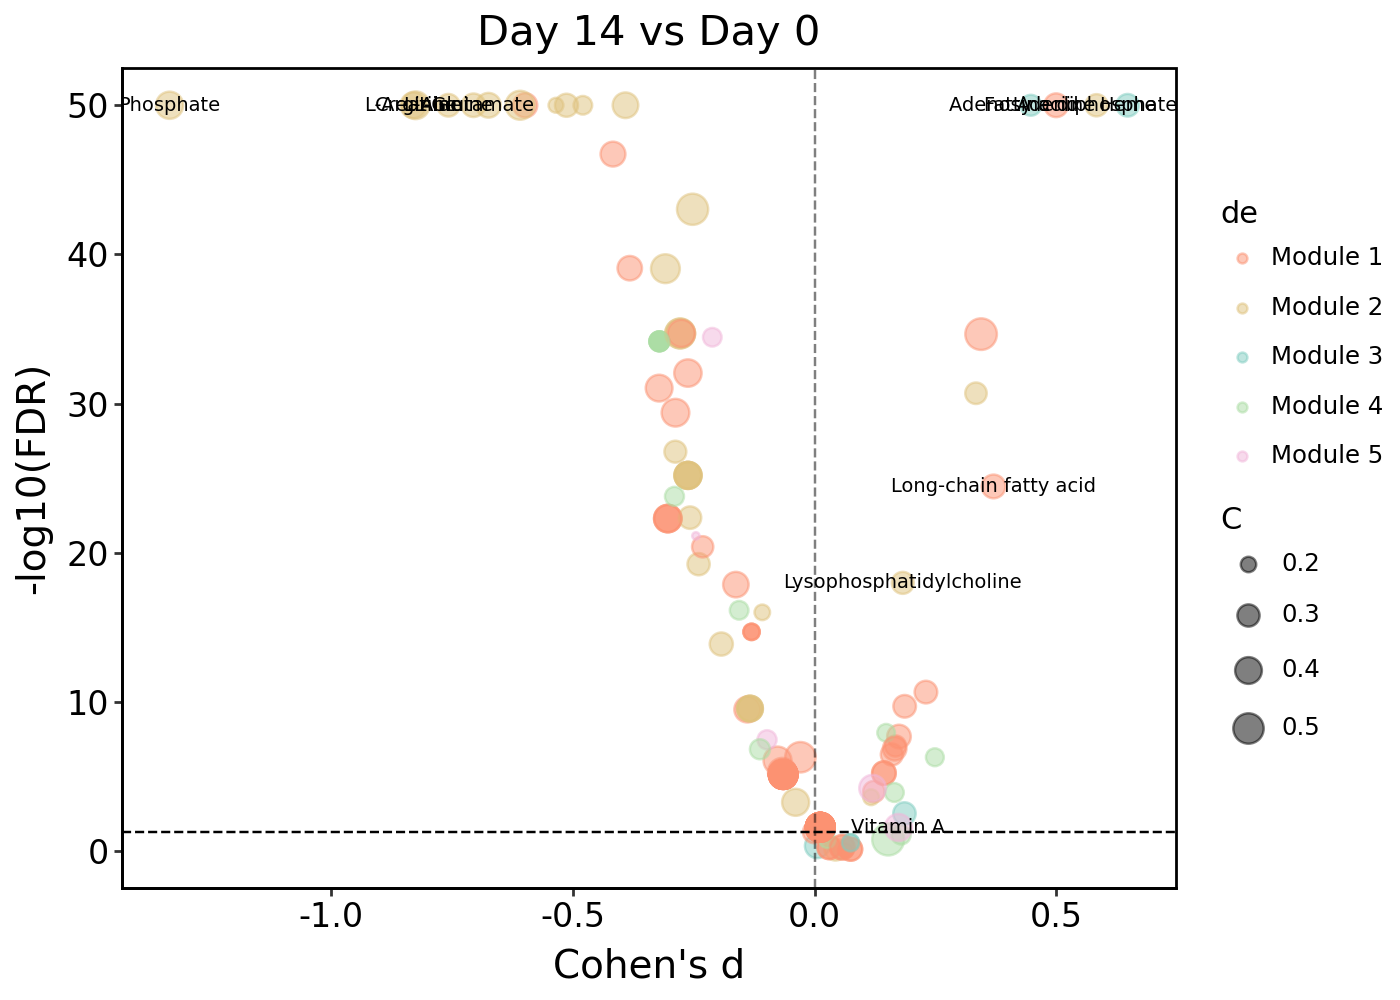

In [223]:
n_metabs = 5
pos_metabs = wilcox_results_vis[wilcox_results_vis['adjusted_pval'] < 0.05].sort_values('cohens_d', ascending=False).index.tolist()
neg_metabs = wilcox_results_vis[wilcox_results_vis['adjusted_pval'] < 0.05].sort_values('cohens_d').index.tolist()
int_metabs = list(set(pos_metabs[:n_metabs]) | set(neg_metabs[:n_metabs])) + ['Vitamin A', 'Lysophosphatidylcholine']
# int_metabs = top3m.index.tolist()
wilcox_results_vis['delabel'] = np.nan
wilcox_results_vis['delabel'][wilcox_results_vis.index.isin(int_metabs)] = wilcox_results_vis.index[wilcox_results_vis.index.isin(int_metabs)]
wilcox_results_vis['min_log10_FDR'] = -1*np.log10(wilcox_results_vis['adjusted_pval'])
wilcox_results_vis['de'] = wilcox_results_vis.index.map(lambda x: f'Module {mod_series.loc[x]}' if x in mod_series.index else "Module -1")
wilcox_results_vis['min_log10_FDR'][wilcox_results_vis['min_log10_FDR'] > 50] = 50

fig = (
    ggplot(wilcox_results_vis, aes(x='cohens_d', y='min_log10_FDR', color = 'de', size='C')) +
    geom_point(alpha=0.5) + 
    geom_text(aes(label="delabel"), data=wilcox_results_vis, color='black', size=7) +
    theme_classic() +
    geom_hline(yintercept=-1*np.log10(0.05), linetype='--', color='black') +
    # geom_vline(xintercept=-0.15, linetype='--', color='black', alpha=0.5) +
    geom_vline(xintercept=0, linetype='--', color='black', alpha=0.5) +
    scale_color_manual(values=palette) +
    ggtitle('Day 14 vs Day 0') + xlab("Cohen's d") + ylab("-log10(FDR)") + 
    # xlim(-0.5, 0.5) + ylim(0, 20) +
    theme(plot_title = element_text(hjust = 0.5, size=15),
            panel_grid_major = element_blank(),
            panel_grid_minor = element_blank(),
            panel_border = element_rect(colour = "black"),
            # legend_position='none',
            axis_text_x= element_text(size = 12, color='black'),
            axis_text_y= element_text(size = 12, color='black'),
            axis_title_x= element_text(size = 14),
            axis_title_y= element_text(size = 14),
    figure_size=(7, 5))
    )
fig.show()
# fig.save(os.path.join(PLOTS_PATH, 'Day_14_vs_Day_0_metab_score_volcano_plot.svg'), format='svg')

#### Module / metabolite group correlation analysis

In [196]:
common_cells = adata.obsm['super_module_scores'].index.intersection(metab_scores_adata.obsm['super_module_scores'].index)
df1a = adata.obsm['super_module_scores'].loc[common_cells]
df2a = metab_scores_adata.obsm['super_module_scores'].loc[common_cells]

corr = pd.DataFrame(index=df1a.columns, columns=df2a.columns, dtype=float)
for m1 in df1a.columns:
    for m2 in df2a.columns:
        corr.at[m1, m2] = df1a[m1].corr(df2a[m2], method='spearman')

In [205]:
colors = list(plt.get_cmap('tab10').colors)
palette_m = {mod: colors[int(mod.split(' ')[1])-1] for mod in adata.obs['top_super_module'].dropna().unique()}

<Figure size 640x480 with 0 Axes>

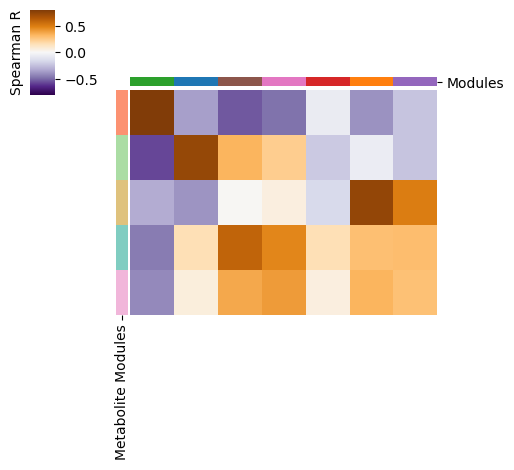

In [216]:
vmin=-0.8
vmax=0.8
# cmap='RdBu_r'
# cmap=sns.color_palette("PiYG", as_cmap=True)
cmap=sns.color_palette("PuOr_r", as_cmap=True)
# cmap=sns.color_palette("PRGn", as_cmap=True)
yticklabels=False

row_colors1 = pd.Series(
    [palette_m[i] for i in corr.index],
    index=corr.index,
)

row_colors = pd.DataFrame({
    "Modules": row_colors1,
})

col_colors1 = pd.Series(
    [palette[i] for i in corr.columns],
    index=corr.columns,
)

col_colors = pd.DataFrame({
    "Metabolite Modules": col_colors1,
})

cm = sns.clustermap(
    corr.T,
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
    xticklabels=False,
    yticklabels=yticklabels,
    row_colors=col_colors,
    col_colors=row_colors,
    rasterized=True,
    figsize=(5,4.75),
)

fig = plt.gcf()
plt.sca(cm.ax_heatmap)
plt.ylabel("")
plt.xlabel("")

cm.ax_row_dendrogram.remove()
cm.ax_col_dendrogram.remove()

plt.sca(cm.ax_row_colors)

# Find the colorbar 'child' and modify
min_delta = 1e99
min_aa = None
for aa in fig.get_children():
    try:
        bbox = aa.get_position()
        delta = (0-bbox.xmin)**2 + (1-bbox.ymax)**2
        if delta < min_delta:
            delta = min_delta
            min_aa = aa
    except AttributeError:
        pass

min_aa.set_ylabel('Spearman R')
min_aa.yaxis.set_label_position("left")

plt.savefig(os.path.join(PLOTS_PATH, 'gene_modules_vs_metab_modules_spearman_correlation_plot.svg'))
plt.show()

#### Circular plot

In [232]:
df = zscore(metab_scores_adata.obsm['super_module_scores'], axis=0)
df = df > 1
super_modules = df.columns
df['cond'] = metab_scores_adata.obs['cond']

In [233]:
M = len(df)  # total number of rows

results = []

for cat1_val in df['cond'].cat.categories:
    for cat2_val in super_modules:
        n = (df['cond'] == cat1_val).sum()
        N = df[cat2_val].sum()
        k = ((df['cond'] == cat1_val) & df[cat2_val]).sum()
        expected = n * N / M
        enrichment = k / expected if expected != 0 else None
        p_value = hypergeom.sf(k-1, M, n, N)
        
        results.append({
            'cond': cat1_val,
            'super_module': cat2_val,
            'n': n,
            'N': N,
            'k': k,
            'expected': expected,
            'enrichment': enrichment,
            'p_value': p_value
        })

results_df = pd.DataFrame(results)

In [234]:
cond_palette = {
    'Day 0': '#ffbb78',
    'Day 14': '#c5b0d5',
}

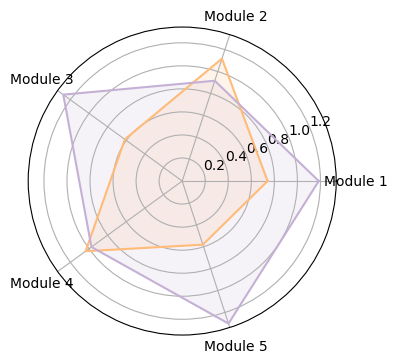

In [238]:
z_score_matrix = results_df.pivot(
    index='super_module',
    columns='cond',
    values='enrichment'
)

module = z_score_matrix.index

plt.figure(figsize =(6, 4))
plt.subplot(polar = True)

z_score_matrix.loc['Module 1 (rep)'] = z_score_matrix.loc['Module 1'].to_dict()

theta = np.linspace(0, 2 * np.pi, len(z_score_matrix['Day 0']))

lines, labels = plt.thetagrids(range(0, 360, int(360/len(module))),
														(module))

for cond in z_score_matrix.columns:
	plt.plot(theta, z_score_matrix[cond], c=cond_palette[cond])
	plt.fill(theta, z_score_matrix[cond], cond_palette[cond], alpha = 0.15)
# plt.yticks(np.arange(0, 5, 1))
plt.savefig(os.path.join(PLOTS_PATH, 'metab_mod_cond_zscore_circular_plot.svg'))
plt.show()